# LIME Experiments on Toy Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from tqdm import tqdm
from statistics import mean

from stability_utils import Sklearn_Lime, LimeTabularExplainerOvr
from utils import bayesian_optimisation


In the custom script *utils*, bayesian optimization framework is borrowed from [Thomas Huijskens repository](https://github.com/thuijskens/bayesian-optimization)  

In the custom script *stability_utils*:  

- **LimeTabularExplainerOvr** class (it is a slightly changed implementation of the homonymous one in the *lime-stability* package), in particular addded:  
  - penalty parameter to set the size of Ridge penalty $\lambda$  
  - added hooks to obtain the points generated inside LIME, their weights and their prediction made by the Ridge Local Model  
  

- **Sklearn_Lime**: wrapper of the LimeTabularExplainerOvr class, in a sklearn estimator fashion.  
This has been done to allow for easier bayesian search over the kernel width parameter. Sklearn_Lime has additional attribute **maxRsquared**, which implements the idea of OptiLIME: setting a specified level of adherence to balance the trade-off between adherence and stability of the LIME explanations.

In [2]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

Set seed for reproducibilty

In [3]:
def set_seed(seed=666):
    """Define the seed for the randomness of the script"""
    np.random.RandomState(seed)
    np.random.seed(seed)
    
seed = 665
set_seed(seed)

Plot/Notebook parameters

In [4]:
colors = ['teal', 'yellowgreen', 'gold']
lw = 2
lime_unit = 9

# Toy Dataset

freely re-adapted from [sklearn - Polynomial Interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)

Build the DGP: $f(X) = X * sin(X) + 10$  
Generate 100 points on the X range $[0,1]$, and randomly keep only 20 of them  
Build a Polynomial Regression model (degree 5) as our ML model

## Generate Dataset

In [5]:
def f(x):
    """ DGP function"""
    return x * np.sin(x) + 10


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

## Polynomial Regression as my ML model

In [6]:
count=1; degree =5
pol = make_pipeline(PolynomialFeatures(degree), Ridge())
pol.fit(X, y)
y_plot_pol = pol.predict(X_plot)
y_pol = pol.predict(X)

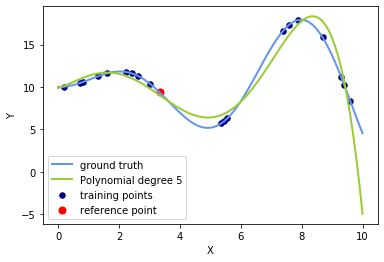

In [7]:
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")
plt.scatter(X[lime_unit], y[lime_unit], color='red',
            s=50, marker='o', label="reference point")
plt.plot(x_plot, y_plot_pol, color=colors[1], linewidth=lw,
         label="Polynomial degree %d" % degree)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='best')
# filename = "../../Paper_Latex/images/Toy_Sin/Toy_Dataset.png"
# plt.savefig(filename,dpi=300,bbox_inches='tight')
plt.show()

# LIME on Toy Dataset

### Parameters

In [8]:
kernel_width=0.01
model = pol
lime_unit = 9

In Regression, Lime gives two coefficients for each single variable (same intensity, opposite sign).  
The one returned by default by the *as_list()* method is the coefficient with dictionary key:1  

LIME performs standardization internally: the generated points are standardized and the LIME coefficients are the ones of the standardized dataset.  
To obtain the LIME line on the plot, we need to standardize the $x$ values before drawing the line.


Nel pacchetto LIME che ho caricato per fare questo notebook, ho tolto il coefficiente $\alpha$ della Ridge, perchè quando la retta avrebbe coefficiente molto grande in valore assoluto (quando sono in un punto molto pendente), allora il coefficiente Ridge tende ad abbassarne il valore a causa della  penalità che impone al coefficiente (alla loro somma di quadrati).  
in generale il coefficiente Ridge fa si che la retta non si trovi esattamente dove dovrebbe essere (e quindi che non corrisponda esattamente alla tangente), però da piu stabilità alle stime. **Adesso ho rimesso $\alpha=1$, cosi sto usando esattamente l'implementazione LIME normale.**   

In [9]:
def lime_line(lime_exp,x_plot):
    """Function to draw the right LIME line on the plot"""
    x_plot_std = (x_plot-X.mean())/X.std()
    lime_plot = lime_exp.intercept[0] + lime_exp.local_exp[1][0][1]*x_plot_std
    return lime_plot



## Kernel Width defines Locality

We already use Ridge Penalty $\lambda=0$ (in our LIME implementation is the parameter *penalty*), since it is the correct specification of the Local Model (**see [Ridge Penalty Section](#Ridge_Penalty)**)

In [10]:
kernel_width_vector = [[0.1,0.3],[0.5,0.7]]

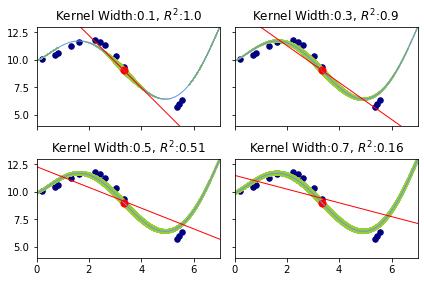

In [11]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
custom_ylim = (4,13)
custom_xlim= (0,7)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

for i,kw in enumerate(kernel_width_vector):
    for j,kernel_width in enumerate(kw):

        lime_explainer = LimeTabularExplainerOvr(X,
                                                 mode="regression",
                                                 verbose=False,
                                                 discretize_continuous=False,
                                                 kernel_width=kernel_width,
                                                 sample_around_instance=True,
                                                 penalty=0,
                                                 random_state=seed
                                                 )
        lime_exp = lime_explainer.explain_instance(X[lime_unit],model.predict)
        weights = lime_explainer.base.weights
        rescaled_weights = 20* (weights- weights.min()) /(weights.max()-weights.min())
        lime_points = pd.concat([pd.DataFrame(lime_explainer.data,columns=["X"]),pd.DataFrame(lime_explainer.lime_preds,columns=["Y"]),
                                 pd.DataFrame(rescaled_weights,columns=["weights"])],axis=1)
        lime_plot = lime_line(lime_exp,x_plot)

        ax[i, j].plot(x_plot, y_plot_pol, color="cornflowerblue", linewidth=1,
             label="ML - Polynomial degree %d" % degree)
        ax[i, j].scatter(x, y, color='navy', s=30, marker='o', label="training points")
        ax[i, j].plot(x_plot,lime_plot,label="LIME line",color="red",linewidth=1)
        ax[i, j].scatter(lime_points.X,lime_points.Y,color='yellowgreen', s=lime_points.weights, marker='o', label="LIME sampled points")
        ax[i, j].scatter(X[lime_unit],y_pol[lime_unit],color='red', s=50, marker='o')
        ax[i, j].title.set_text(r"Kernel Width:{}, $R^2$:{}".format(kernel_width,round(lime_exp.score,2)))

        
fig.tight_layout(pad=1)
plt.show()

# fig.savefig("../../Paper_Latex/images/Toy_Sin/kernel_width_grid.png",dpi=300,bbox_inches='tight')

<a id='Ridge_Penalty'></a>


## Ridge Penalty is harmful for LIME

In [12]:
kernel_width_vector = [[0.01,0.03],[0.05,0.07]]
ridge_penalty_vector = [0,1]

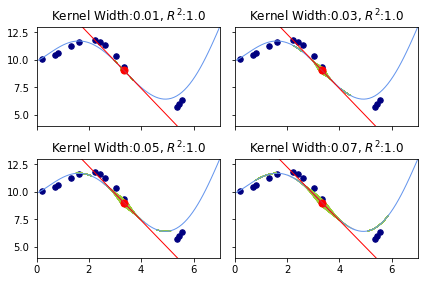

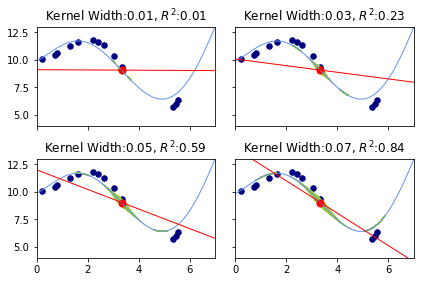

In [13]:
for ridge_penalty in ridge_penalty_vector:
    fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
    custom_ylim = (4, 13)
    custom_xlim = (0, 7)
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

    for i, kw in enumerate(kernel_width_vector):
        for j, kernel_width in enumerate(kw):

            lime_explainer = LimeTabularExplainerOvr(X,
                                                     mode="regression",
                                                     verbose=False,
                                                     discretize_continuous=False,
                                                     kernel_width=kernel_width,
                                                     sample_around_instance=True,
                                                     penalty=ridge_penalty,
                                                     random_state=seed
                                                     )
            lime_exp = lime_explainer.explain_instance(
                X[lime_unit], model.predict)
            weights = lime_explainer.base.weights
            rescaled_weights = 20 * \
                (weights - weights.min()) / (weights.max()-weights.min())
            lime_points = pd.concat([pd.DataFrame(lime_explainer.data, columns=["X"]), 
                                     pd.DataFrame(lime_explainer.lime_preds, columns=["Y"]),
                                     pd.DataFrame(rescaled_weights, columns=["weights"])], axis=1)
            lime_plot = lime_line(lime_exp, x_plot)

            ax[i, j].plot(x_plot, y_plot_pol, color="cornflowerblue", linewidth=1,
                          label="ML - Polynomial degree %d" % degree)
            ax[i, j].scatter(x, y, color='navy', s=30,
                             marker='o', label="training points")
            ax[i, j].plot(x_plot, lime_plot, label="LIME line",
                          color="red", linewidth=1)
            ax[i, j].scatter(lime_points.X, lime_points.Y, color='yellowgreen',
                             s=lime_points.weights, marker='o', label="LIME sampled points")
            ax[i, j].scatter(X[lime_unit], y_pol[lime_unit],
                             color='red', s=50, marker='o')
            ax[i, j].title.set_text(r"Kernel Width:{}, $R^2$:{}".format(
                kernel_width, round(lime_exp.score, 2)))

    fig.tight_layout(pad=1)
    plt.show()
    # filename = "../../Paper_Latex/images/Toy_Sin/Ridge"+str(ridge_penalty)+"_grid.png"
    # fig.savefig(filename,dpi=300,bbox_inches='tight')

## Relationship $R^2$, CSI, kernel_width

**Generic Logistic Function**:  
References: [useful blog](http://www.indianalytics.de/?p=41), [StackExchange question on Implementation](https://stackoverflow.com/questions/60160803/scipy-optimize-curve-fit-for-logistic-function)  

$f(x) = \frac{L}{1+\exp{-k(x-x_0)}}+b$  

with:  

- $x_{0}$ = the $x$ value of the logistic's saddle point
- $L$ = logistic upper bound
- $k$  = logistic growth rate (steepness of the curve)
- $b$ = logistic lower bound 

Logistic is able to find monotonous non-linear relationships in the data


In [14]:
def logistic(x, L ,x0, k, b):
    """Fits generic Logistic Function through a set of 1d points"""
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)


def mae(y,y_pred):
    return np.abs(y-y_pred).mean()

Create a grid of kernel width values and evaluate both CSI and $R^2$

In [15]:
kernel_width_vector = list(np.arange(0.01,1.2,0.01).round(2))
len(kernel_width_vector)

119

### Graphical evaluation (on Unit 9)

In [16]:
csi_list = []
vsi_list = []
R_squared_list = []
for kernel_width in tqdm(kernel_width_vector):
    lime_explainer = LimeTabularExplainerOvr(X,
                                             mode="regression",
                                             verbose=False,
                                             discretize_continuous=False,
                                             kernel_width=kernel_width,
                                             sample_around_instance=True,
                                             penalty=0,
                                             random_state=seed)
    csi, vsi,_ = lime_explainer.check_stability(X[lime_unit, ], model.predict)
    lime_exp = lime_explainer.explain_instance(X[lime_unit], model.predict)
    csi_list.append(csi)
    vsi_list.append(vsi)
    R_squared_list.append(lime_exp.score)
    # print("CSI: {}".format(csi))
    # print("VSI: {}".format(vsi))
    # print("R squared: {}".format(lime_exp.score))
    # print("kernel width: {}".format(kernel_width))
csi_list = [csi/100 for csi in csi_list]
vsi_list = [vsi/100 for vsi in vsi_list]

100%|██████████| 119/119 [01:31<00:00,  1.31it/s]


R_growth_rate: -10.784189109939787
R_mae_results: 0.005165752524745642
CSI_growth_rate: 7.203447628195789
CSI_mae_results: 0.025938005698167673


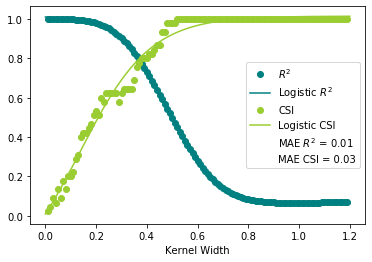

In [17]:
p0 = [1, np.median(kernel_width_vector),1,0] # this is a mandatory initial guess
poptR, _ = curve_fit(logistic, kernel_width_vector, R_squared_list, p0, method='lm')
poptCSI, _ = curve_fit(logistic, kernel_width_vector, csi_list, p0, method='lm')
R_pred = logistic(kernel_width_vector,*poptR)
CSI_pred = logistic(kernel_width_vector,*poptCSI)

R_growth_rate = poptR[2]
R_mae_results = mae(R_squared_list,R_pred)
CSI_growth_rate = poptCSI[2]
CSI_mae_results = mae(csi_list,CSI_pred)

#logistic plots
kw = np.linspace(0, 1.2, 1000)
yR = logistic(kw, *poptR)
yCSI = logistic(kw, *poptCSI)

plt.plot(kernel_width_vector, R_squared_list, 'o', label=r'$R^2$',c=colors[0])
plt.xlabel("Kernel Width")
plt.plot(kw,yR, label=r'Logistic $R^2$',c=colors[0])
plt.plot(kernel_width_vector, csi_list, 'o', label='CSI',c=colors[1])
plt.plot(kw,yCSI, label='Logistic CSI',c=colors[1])
plt.plot([], [], ' ', label=r"MAE $R^2$ = {}".format(round(R_mae_results,2)))
plt.plot([], [], ' ', label="MAE CSI = {}".format(round(CSI_mae_results,2)))

plt.legend(loc="best")
# plt.savefig("../../Paper_Latex/images/Toy_Sin/trend_R_CSI.png",dpi=300, bbox_inches='tight')

print("R_growth_rate: {}".format(R_growth_rate))
print("R_mae_results: {}".format(R_mae_results))
print("CSI_growth_rate: {}".format(CSI_growth_rate))
print("CSI_mae_results: {}".format(CSI_mae_results))

### Evaluation on all the points in the Dataset 
Compare the MAE results and the $k$ growth rate values of the logistic functions, estimated per each point

In [18]:
experiment_explanations = []
experiment_data = pd.DataFrame()

for i in tqdm(range(len(x))):
    unit_explanations = []
    r_quadro = []
    csi_list = []
    vsi_list = []
    for kernel_width in kernel_width_vector:

        lime_explainer = LimeTabularExplainerOvr(X,
                                                 mode="regression",
                                                 verbose=False,
                                                 discretize_continuous=False,
                                                 kernel_width=kernel_width,
                                                 sample_around_instance=True,
                                                 penalty=0)
        csi, vsi,_ = lime_explainer.check_stability(
            X[lime_unit, ], model.predict)
        lime_exp = lime_explainer.explain_instance(X[lime_unit], model.predict)
        csi_list.append(csi)
        vsi_list.append(vsi)
        r_quadro.append(lime_exp.score)
        unit_explanations.append(lime_exp)

    csi_list = [csi/100 for csi in csi_list]
    vsi_list = [vsi/100 for vsi in vsi_list]

    experiment_explanations.append(unit_explanations)

    single_unit = pd.concat([
        pd.Series(np.repeat(i, len(kernel_width_vector)), name="Unit"),
        pd.Series(kernel_width_vector, name="kernel_width"),
        pd.Series(r_quadro, name="Rsquared"),
        pd.Series(csi_list, name="CSI"),
        pd.Series(vsi_list, name="VSI")], axis=1)

    experiment_data = pd.concat([experiment_data, single_unit])

experiment_data.reset_index(inplace=True)

100%|██████████| 20/20 [26:38<00:00, 79.91s/it]


In [19]:
R_mae_results = []; CSI_mae_results = []
R_growth_rate = []; CSI_growth_rate = []
for unit in set(experiment_data.Unit):
    b = experiment_data.loc[experiment_data.Unit == unit,:]

    p0 = [1, np.median(b.kernel_width),1,0] # this is a mandatory initial guess
    poptR, _ = curve_fit(logistic, b.kernel_width, b.Rsquared, p0, method='lm')
    poptCSI, _ = curve_fit(logistic, b.kernel_width, b.CSI, p0, method='lm')
    R_pred = logistic(b.kernel_width,*poptR)
    CSI_pred = logistic(b.kernel_width,*poptCSI)

    R_growth_rate.append(poptR[2])
    R_mae_results.append(mae(b.Rsquared,R_pred))
    CSI_growth_rate.append(poptCSI[2])
    CSI_mae_results.append(mae(b.CSI,CSI_pred))

print(r"mean of $R^2$ MAE: {}".format(mean(R_mae_results)))
print(r"max of $R^2$ growth rate: {}".format(max(R_growth_rate)))
print("mean of CSI MAE: {}".format(mean(CSI_mae_results)))
print("min of CSI growth rate: {}".format(min(CSI_growth_rate)))


mean of $R^2$ MAE: 0.006441924973434081
max of $R^2$ growth rate: -10.219521752564114
mean of CSI MAE: 0.04122382839913258
min of CSI growth rate: 7.754350421848134


# OptiLIME on Unit 9

In [20]:
maxRsquared = 0.9

In [21]:
def OptiLIME_loss(kernel_width):
    single_lime = Sklearn_Lime(mode="regression",
                               verbose=False,
                               discretize_continuous=False,
                               kernel_width=kernel_width,
                               sample_around_instance=True,
                               penalty=0,
                               epsilon=None,
                               num_samples=5000,
                               maxRsquared=maxRsquared,
                               random_state=seed
                              )
    single_lime.fit(X)
    return single_lime.score(X[lime_unit],model.predict)

bounds = np.array([0.01, 1.2]).reshape(1, -1)

kw, R_squared = bayesian_optimisation(n_iters=40,
                               sample_loss=OptiLIME_loss,
                               bounds=bounds,
                               n_pre_samples=20,
                               random_search=False)

bayes_results = pd.concat(
    [pd.DataFrame(kw, columns=["kernel_width"]), 
     pd.DataFrame(R_squared, columns=["R_squared"])],
    axis=1)

In [22]:
best_width = float(kw[R_squared.argmax()])
best_Rquadro = R_squared.max()
print(("Best Width: {}".format(best_width)))
print(("Best Rquadro: {}".format(best_Rquadro)))

Best Width: 0.29632932676989265
Best Rquadro: 0.8986129759945973


Evaluate the CSI value for the points sampled in Bayesian Optimization

In [23]:
csi_vals = []

for kernel_width in tqdm(bayes_results.kernel_width):
    
    single_lime = Sklearn_Lime(mode="regression",
                               verbose=False,
                               discretize_continuous=False,
                               kernel_width=kernel_width,
                               sample_around_instance=True,
                               penalty=0,
                               epsilon=None,
                               num_samples=5000,
                               maxRsquared=maxRsquared,
                               random_state=seed
                              )
    single_lime.fit(X)
    csi,_,_ =  single_lime.my_lime.check_stability(X[lime_unit,],model.predict)
    csi_vals.append(csi)
csi_vals = [csi/100 for csi in csi_vals]

100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


In [24]:
bayes_results = pd.concat([bayes_results,
                           pd.DataFrame(csi_vals,columns=["csi"])],
                          axis=1)
bayes_results.sort_values("kernel_width", inplace=True)
bayes_results.head()

,kernel_width,R_squared,csi
10,0.011546,0.800001,0.0444
4,0.056738,0.800151,0.0667
2,0.123212,0.802903,0.2667
5,0.196059,0.819455,0.5111
3,0.245959,0.848488,0.6000


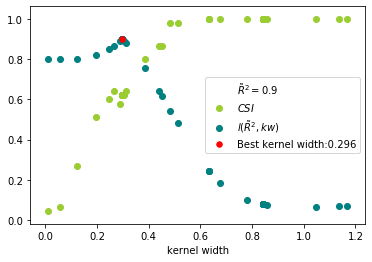

In [25]:
plt.scatter(bayes_results.kernel_width,bayes_results.csi,label=r'$CSI$',color = colors[1])
plt.scatter(bayes_results.kernel_width,bayes_results.R_squared,label=r'$l(\tilde{R}^2,kw)$',color = colors[0])
plt.scatter(best_width,best_Rquadro,c = "red", s=30,label="Best kernel width:{}".format(round(best_width,3)))
plt.plot([], [], ' ', label=r'$\tilde{R}^2 = 0.9$')

plt.xlabel("kernel width")
plt.legend(loc='best')

# filename = "../../Paper_Latex/images/Toy_Sin/Bayes_Search.png" 
# plt.savefig(filename,dpi=300,bbox_inches='tight')

plt.show()
